In [79]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.aqua.components.optimizers import GSLS, L_BFGS_B, SLSQP, TNC, CRS, DIRECT_L, DIRECT_L_RAND, ESCH, ISRES
import math
import random
import numpy as np
from numpy import pi
import time
import itertools
import matplotlib.pyplot as plt
import pickle

## Auxiliary functions

In [80]:
""" save and load results to and from a file """
def save_results_to_disk(obj, name ):
    with open('results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_results_from_file(name ):
    with open('results/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [12]:
def prepare_initial_state(theta, phase):
    """ Prepare initial state """
    return (math.cos(theta) * (1 + 0j),
        (math.sin(theta) * math.e**(1j * phase) + 0 + 0j))

In [13]:
def convert_counts_to_final_result(counts) -> int:
    """ Convert the execution result to the final measured value: 0 or 1 """
    if "0" in counts:
        return 0
    return 1

In [14]:
def set_random_eta(eta0, eta1):
    """ return a random choice from eta0 and eta1 with the correspondent key name """
    eta_value = random.choice([eta0, eta1])
    if eta_value == eta0:
        return eta_value, 0
    return eta_value, 1

In [15]:
def compute_damping_channel(theta, phase, eta, phi_rx, phi_ry, backend) -> int:
    """ one-time execution of the amplitude damping circuit using the passed parameters 
        Returns: the execution measured result: either 0 or 1
    """
    qreg_q = QuantumRegister(2, 'q')
    creg_c = ClassicalRegister(1, 'c')

    initial_state = prepare_initial_state(theta, phase)

    circuit = QuantumCircuit(qreg_q, creg_c)
    circuit.initialize([initial_state[0],
                        initial_state[1]], qreg_q[0])
    circuit.reset(qreg_q[1])
    circuit.cry(2 * eta, qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rx(phi_rx, qreg_q[0])
    circuit.ry(phi_ry, qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])

    counts = execute(circuit, backend, shots=1).result().get_counts(circuit)
    return convert_counts_to_final_result(counts)

In [16]:
def compute_random_damping_channel(configuration, backend):
    """ run a one-time execution on the given backend device randomly selectiong the eta to be used and return the measured result """
    eta_value, eta_used = set_random_eta(configuration['eta0'], configuration['eta1'])
    result = compute_damping_channel(configuration['theta'], configuration['phase'], eta_value, configuration['phi_rx'], configuration['phi_ry'], backend)

    return {
        "result": result,
        "eta_used": eta_used
    }

In [19]:
def guess_eta_used(real_measured_result):
    """ Decides which eta was used on the real execution.
        It is a silly guess.
        It returns the eta used is 0 when the measured result is 0, and 1 otherwise
    """
    return real_measured_result

In [20]:
def check_value(real_eta, guess_eta): 
    if real_eta == guess_eta: return 1
    return 0

In [21]:
def play_and_guess_one_case(configuration, backend):
    """ Execute a real execution with a random eta from the two passed, 
        guess which one was used on the exection and
        check the result.
        Returns 1 on success (it was a correct guess) or 0 on fail (it was an incorrect guess) 
    """
    real_result = compute_random_damping_channel(configuration, backend)
    guess_eta = guess_eta_used(real_result['result'])
    return check_value(real_result['eta_used'], guess_eta)

In [29]:
def get_combinations_two_etas_without_repeats(input_list_eta):
    """ from a given list of attenuations (etas) create a 
        list of all combinatorial pairs of possible etas
        without repeats (order does not matter).
        For us it is the same testing first eta 0.1 and second eta 0.2 
        than first eta 0.2 and second eta 0.1
    """
    list_eta = input_list_eta
     # when there is only one element, we add the same element
    if len(list_eta) == 1:
        list_eta.append(list_eta[0])
    # get combinations of two etas without repeats
    return list(itertools.combinations(list_eta, 2))

## Creating our cost function to be minimized (minimizing the error)

In [23]:
def play_one_configuration(configuration, backend, plays=1000):
    """ Play the play_and_guess game for the number of plays for the configuration of input parameters.
        Returns the average success probability for all the plays with the given configuration. 
    """
    success_counts = 0
    for play in range(plays):
        success_counts += play_and_guess_one_case(configuration, backend)
    return success_counts/plays

In [24]:
def cost_function(params):
    """ Computes the cost of running a specific configuration.
        Cost is computed as 1 (perfect probability) - given probability [0,1]
    """
    backend = backend=Aer.get_backend('qasm_simulator')

    configuration = {
        "theta": params[0],
        "phase": params[1],
        "phi_rx": params[2],
        "phi_ry": params[3],
        "eta0": GLOBAL_ETA0,
        "eta1": GLOBAL_ETA1
    }
    return 1 - play_one_configuration(configuration, backend, plays=100)

## Parameter Optimization for the best configuration

In [28]:
def compute_best_configuration( optimizer_algorithms=['CRS'], 
                                list_optimizer_iterations=[1000], 
                                list_step_size=[pi/10], 
                                list_iterations_per_algorithm=[1]):
    """ Find out the best configuration with a global pair of etas (channels) trying out a list of specified optimizat algorithm """
    # Create the initial parameters and set the bounds
    initial_params = [0, 0, 0, 0]
    variable_bounds = [
                        (0, pi/2), # theta
                        (0, 2*pi), # phase
                        (0, 2*pi), # rx
                        (0, 2*pi)  # ry
                        ]
    best_probability = 0
    best_configuration = []
    best_optimizer_algorithm = ""

    for optimizer_algorithm, optimizer_iterations, step_size, iterations in zip(optimizer_algorithms, 
                                                                    list_optimizer_iterations, 
                                                                    list_step_size, 
                                                                    list_iterations_per_algorithm):
        print("Analyzing Optimizer Algorithm: ", optimizer_algorithm)
        if optimizer_algorithm == 'GSLS':
            # optimizer = GSLS()
            optimizer = GSLS(maxiter=optimizer_iterations, max_eval=optimizer_iterations, initial_step_size=step_size)
        if optimizer_algorithm == 'L_BFGS_B':
            # optimizer = L_BFGS_B()
            optimizer = L_BFGS_B(maxfun=optimizer_iterations, maxiter=optimizer_iterations, epsilon=step_size)
        if optimizer_algorithm == 'SLSQP':
            # optimizer = SLSQP()
            optimizer = SLSQP(maxiter=optimizer_iterations,  eps=step_size)
        if optimizer_algorithm == 'TNC':
            # optimizer = TNC()
            optimizer = TNC(maxiter=optimizer_iterations, eps=step_size)
        if optimizer_algorithm == 'BOBYQA':
            optimizer = BOBYQA(maxiter=optimizer_iterations)
        if optimizer_algorithm == 'IMFIL':
            optimizer = BOBYQA(maxiter=optimizer_iterations)
        if optimizer_algorithm == 'SNOBFIT':
            optimizer = BOBYQA(maxiter=optimizer_iterations)
        if optimizer_algorithm == 'CRS':
            optimizer = CRS(max_evals=optimizer_iterations)
        if optimizer_algorithm == 'DIRECT_L':
            optimizer = DIRECT_L(max_evals=optimizer_iterations)
        if optimizer_algorithm == 'DIRECT_L_RAND':
            optimizer = DIRECT_L_RAND(max_evals=optimizer_iterations)
        if optimizer_algorithm == 'ESCH':
            optimizer = ESCH(max_evals=optimizer_iterations)
        if optimizer_algorithm == 'ISRES':
            optimizer = ISRES(max_evals=optimizer_iterations)

        
        for i in range(iterations):
            ret = optimizer.optimize(num_vars=len(initial_params), 
                                    objective_function=cost_function, 
                                    variable_bounds=variable_bounds,
                                    initial_point=initial_params)
            print("Best Average Probability:", 1 - ret[1])
            if (1-ret[1]) > best_probability:
                best_probability = 1-ret[1]
                best_configuration = ret[0]
                best_optimizer_algorithm = optimizer_algorithm

    # Print results
    print("Final Best Optimizer Algorithm: ", best_optimizer_algorithm)
    print("Final Best Average Probability:", best_probability)
    print("Parameters Found: " + u"\u03B8" + " = " + str(int(math.degrees(best_configuration[0]))) + u"\u00B0" +
                            ", Phase = " + str(int(math.degrees(best_configuration[1]))) + u"\u00B0" + 
                            ", " + u"\u03D5" + "rx = " + str(int(math.degrees(best_configuration[2]))) + u"\u00B0" + 
                            ", " + u"\u03D5" + "ry = " + str(int(math.degrees(best_configuration[3]))) + u"\u00B0" +
                            ", " + u"\u03B7" + u"\u2080" + " = " + str(int(math.degrees(GLOBAL_ETA0))) + u"\u00B0" + 
                            ", " + u"\u03B7" + u"\u2081" + " = " + str(int(math.degrees(GLOBAL_ETA1))) + u"\u00B0")
    return {
        "best_optimizer_algorithm": best_optimizer_algorithm,
        "best_probability": best_probability,
        "best_configuration": best_configuration
    }


## Find out the best configuration ($\theta, phase, rx, ry$) and success probability for each pair of $\eta$ attenuation levels from 0 to $\frac{\pi}{2}$

In [63]:
np.append(np.arange(0, pi/2, pi/2/20), pi/2)

array([0.        , 0.07853982, 0.15707963, 0.23561945, 0.31415927,
       0.39269908, 0.4712389 , 0.54977871, 0.62831853, 0.70685835,
       0.78539816, 0.86393798, 0.9424778 , 1.02101761, 1.09955743,
       1.17809725, 1.25663706, 1.33517688, 1.41371669, 1.49225651,
       1.57079633])

In [66]:
len(np.append(np.arange(0, pi/2, pi/2/20), pi/2))*8/60

2.8

In [67]:
# create the channels etas to be used
# from 0 to pi/2 in steps of pi/2/2, and adding the pi/2 as the last value
list_eta = np.append(np.arange(0, pi/2, pi/2/20), pi/2)

optimizer_algorithms = ['CRS']
list_optimizer_iterations=[1000]
list_step_size=[pi/10]
list_iterations_per_algorithm=[1]
# optimizer_algorithms = ['CRS', 'DIRECT_L', 'DIRECT_L_RAND', 'ESCH', 'ISRES']
# list_optimizer_iterations=[1000, 1000, 1000, 1000, 1000]
# list_step_size=[pi/10, pi/10, pi/10, pi/10, pi/10]
# list_iterations_per_algorithm=[1, 1, 1, 1, 1]
# optimizer_algorithms = ['GSLS', 'L_BFGS_B', 'SLSQP', 'TNC']
# list_optimizer_iterations=[10000, 1000, 100, 100]
# list_step_size=[pi/10, pi/10, pi/10, pi/10]
# list_iterations_per_algorithm=[1, 1, 1, 1]
two_pair_etas = get_combinations_two_etas_without_repeats(list_eta)
probabilities = []
configurations = []
best_algorithm = []
eta_pairs = []

program_start_time = time.time()
print("Starting the execution")

for eta_pair in two_pair_etas:
    start_time = time.time()
    GLOBAL_ETA0=eta_pair[0]
    GLOBAL_ETA1=eta_pair[1]
    result = compute_best_configuration(optimizer_algorithms=optimizer_algorithms,
                                        list_optimizer_iterations=list_optimizer_iterations,
                                        list_step_size=list_step_size, 
                                        list_iterations_per_algorithm=list_iterations_per_algorithm)
    probabilities.append(result['best_probability'])
    configurations.append(result['best_configuration'])
    best_algorithm.append(result['best_optimizer_algorithm'])
    eta_pairs.append([str(int(math.degrees(eta_pair[0]))), str(int(math.degrees(eta_pair[1])))])
    end_time = time.time()
    print("total minutes taken this pair of etas: ", int(np.round((end_time - start_time)/60)))
    print("total minutes taken so far: ", int(np.round((end_time - program_start_time)/60)))

end_time = time.time()
print("total minutes of execution time: ", int(np.round((end_time - program_start_time)/60)))
print("All guesses have been calculated")
print(f'Total pair of etas tested: {len(two_pair_etas)}')

result = {
    "eta_pairs": eta_pairs,
    "best_algorithm": best_algorithm,
    "probabilities": probabilities,
    "configurations": configurations
}

= 90°, Phase = 360°, ϕrx = 359°, ϕry = 191°, η₀ = 36°, η₁ = 90°
total minutes taken this pair of etas:  7
total minutes taken so far:  1699
Analyzing Optimizer Algorithm:  CRS
Best Average Probability: 0.69
Final Best Optimizer Algorithm:  CRS
Final Best Average Probability: 0.69
Parameters Found: θ = 18°, Phase = 45°, ϕrx = 162°, ϕry = 330°, η₀ = 40°, η₁ = 45°
total minutes taken this pair of etas:  7
total minutes taken so far:  1707
Analyzing Optimizer Algorithm:  CRS
Best Average Probability: 0.71
Final Best Optimizer Algorithm:  CRS
Final Best Average Probability: 0.71
Parameters Found: θ = 90°, Phase = 29°, ϕrx = 353°, ϕry = 132°, η₀ = 40°, η₁ = 49°
total minutes taken this pair of etas:  7
total minutes taken so far:  1714
Analyzing Optimizer Algorithm:  CRS
Best Average Probability: 0.73
Final Best Optimizer Algorithm:  CRS
Final Best Average Probability: 0.73
Parameters Found: θ = 43°, Phase = 323°, ϕrx = 220°, ϕry = 347°, η₀ = 40°, η₁ = 54°
total minutes taken this pair of et

In [31]:
result

{'eta_pairs': [['0', '45'], ['0', '90'], ['45', '90']],
 'best_algorithm': ['CRS', 'CRS', 'CRS'],
 'probabilities': [0.89, 1.0, 0.87],
 'configurations': [array([1.57079633, 6.28318531, 0.        , 3.2576572 ]),
  array([1.57079633, 4.36100807, 3.07515244, 6.28318531]),
  array([1.50165274, 0.17955026, 3.569055  , 6.28318531])]}

In [82]:
""" Save results to disk """
# save_results_to_disk(result, name='20210320_results_CRS')

In [83]:
""" Load results from a file """
# loaded_results = load_results_from_file(name='20210320_results_CRS')


## Plotting the results

In [55]:
def plot_scatter(results, title):
    X = []
    Y = []
    x_label = "Eta Pairs"
    
    if title == "Success Probability for each Eta pair": 
        Y = results['probabilities']
        for eta_pair in results['eta_pairs']:
            X.append(eta_pair[0] + ' ' + eta_pair[1])
        y_label = "Success Probability"
    if title == "Input State for each Eta pair": 
        for eta_pair,configuration in zip(results['eta_pairs'],results['configurations']):
            X.append(eta_pair[0] + ' ' + eta_pair[1])
            Y.append(str(int(math.degrees(configuration[0]))) + ' ' + str(int(math.degrees(configuration[1]))))
        y_label = "Input States"
    if title == "Measurement angles for each Eta pair": 
        for eta_pair,configuration in zip(results['eta_pairs'],results['configurations']):
            X.append(eta_pair[0] + ' ' + eta_pair[1])
            Y.append(str(int(math.degrees(configuration[2]))) + ' ' + str(int(math.degrees(configuration[3]))))
        y_label = "Measurement angles"
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title, fontsize=20)
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.scatter(X, Y)
    plt.show()

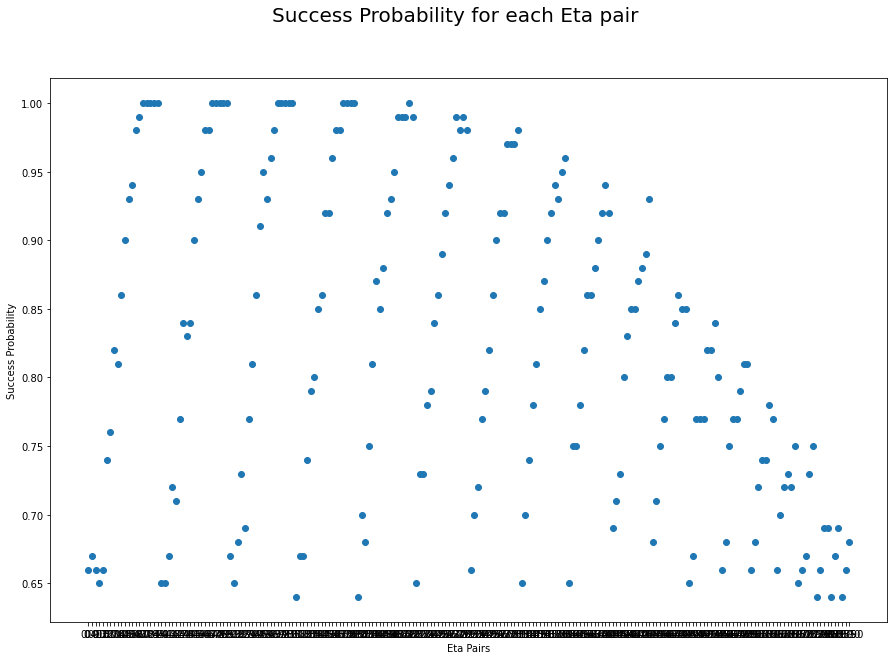

In [69]:
plot_scatter(result, title='Success Probability for each Eta pair')

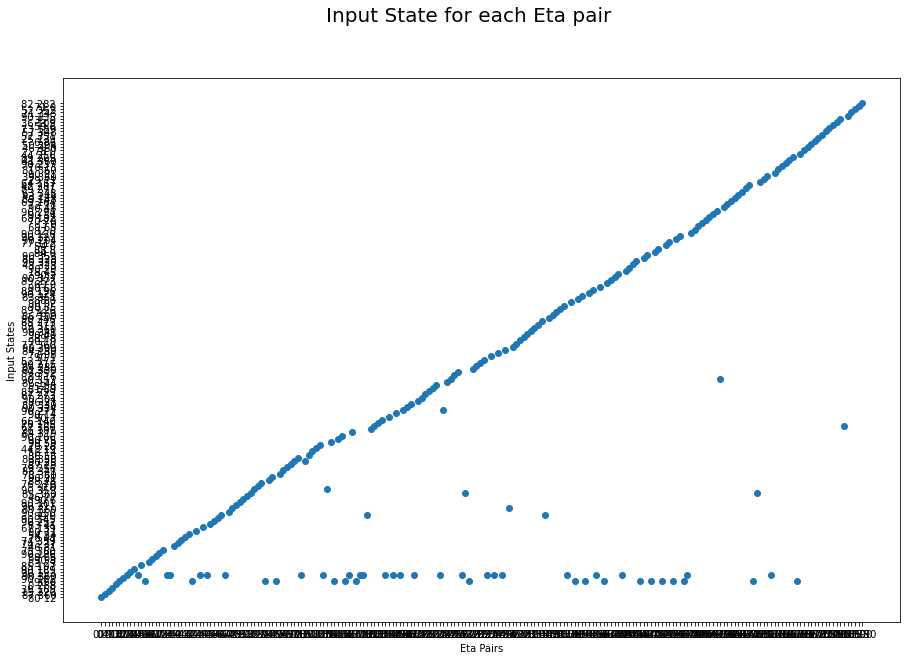

In [70]:
plot_scatter(result, title='Input State for each Eta pair')

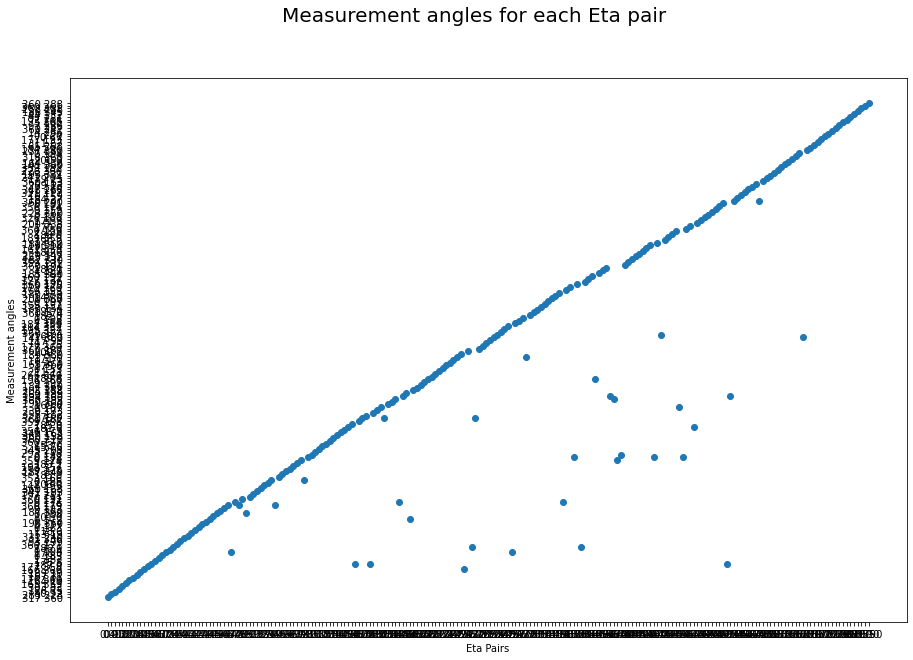

In [71]:
plot_scatter(result, title="Measurement angles for each Eta pair")